In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy

from sklearn.decomposition import PCA

sys.path.insert(1, '../metadl/baselines/sentive_ai')
from sentive.sentive_vision_network import sentive_vision_network

from sentive.sentive_brain import sentive_brain

root_ep = 'episode_'
suf_eptest = '_1.csv'
root_test= 'test_'

episode = np.zeros([1,5,28,28,2])
test = np.zeros([5, 28,28,2])
for i in range(5):
    episode[0][i][:,:,0] = np.loadtxt(root_ep+str(i)+suf_eptest)
    episode[0][i][:,:,1] = np.loadtxt(root_ep+str(i)+suf_eptest)

    test[i][:,:,0] = np.loadtxt(root_test+str(i)+suf_eptest)
    test[i][:,:,1] = np.loadtxt(root_test+str(i)+suf_eptest)


nombre de neurones taille 1: 47
sub_pxl_map
nb neurones couche 2 : 46
nombre de neurones couche 1 & 2: 94
nombre de neurones taille 1: 74
nb neurones couche 2 : 73
nombre de neurones couche 1 & 2: 148
nombre de neurones taille 1: 61
nb neurones couche 2 : 60
nombre de neurones couche 1 & 2: 122
nombre de neurones taille 1: 65
nb neurones couche 2 : 64
nombre de neurones couche 1 & 2: 130


/Users/oliviermanette/Documents/Sentive One Shot Learning Omniglot/sandbox metadl/../metadl/baselines/sentive_ai/sentive/sentive_neuron_helper.py:386: RuntimeWarning: invalid value encountered in arccos
  angle =  signe * np.arccos(np.sum(np.multiply(np_c_1,np_c_2))/(np.sqrt(np.sum(np.power(np_c_1,2)))*np.sqrt(np.sum(np.power(np_c_2,2)))))
/Users/oliviermanette/Documents/Sentive One Shot Learning Omniglot/sandbox metadl/../metadl/baselines/sentive_ai/sentive/sentive_neuron_helper.py:386: RuntimeWarning: invalid value encountered in arccos
  angle =  signe * np.arccos(np.sum(np.multiply(np_c_1,np_c_2))/(np.sqrt(np.sum(np.power(np_c_1,2)))*np.sqrt(np.sum(np.power(np_c_2,2)))))
/Users/oliviermanette/Documents/Sentive One Shot Learning Omniglot/sandbox metadl/../metadl/baselines/sentive_ai/sentive/sentive_neuron_helper.py:386: RuntimeWarning: invalid value encountered in arccos
  angle =  signe * np.arccos(np.sum(np.multiply(np_c_1,np_c_2))/(np.sqrt(np.sum(np.power(np_c_1,2)))*np.sqrt(np.s

nombre de neurones taille 1: 30
nb neurones couche 2 : 29
nombre de neurones couche 1 & 2: 60


/Users/oliviermanette/Documents/Sentive One Shot Learning Omniglot/sandbox metadl/../metadl/baselines/sentive_ai/sentive/sentive_neuron_helper.py:386: RuntimeWarning: invalid value encountered in arccos
  angle =  signe * np.arccos(np.sum(np.multiply(np_c_1,np_c_2))/(np.sqrt(np.sum(np.power(np_c_1,2)))*np.sqrt(np.sum(np.power(np_c_2,2)))))


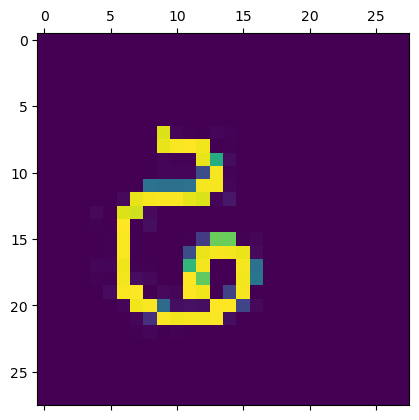

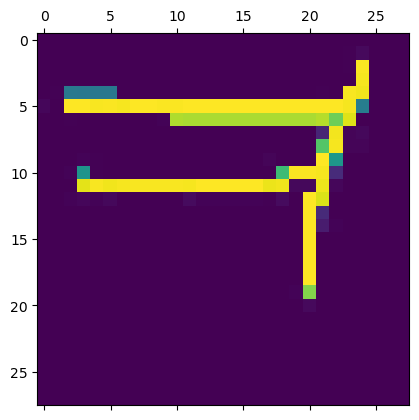

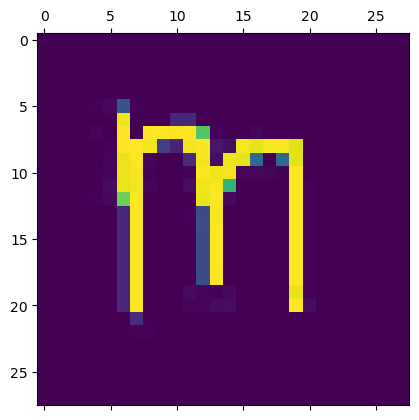

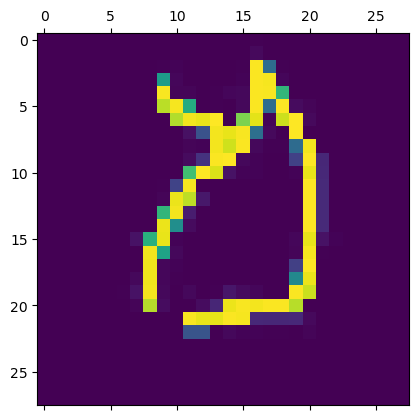

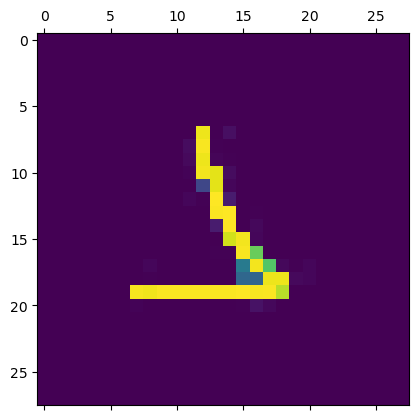

In [2]:
sbrain = sentive_brain(episode,5)

In [3]:
## Couche 3 potentielle :

sbrain.nnet[0].nrn_tls.new_layer()
nb  = sbrain.nnet[0].nrn_tls.add_new_nrn()
nb_min_nrn3 = nb
lst_nrn3_pos = [nb]
nrn3 = sbrain.nnet[0].nrn_tls.lst_nrns[nb].neuron
prevs_nrn3 = [nrn3]

remaining_nrn2_id = {}
i = 0
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        if i==0: 
            crnt_nrn = copy.deepcopy(nrn2)
        else:
            remaining_nrn2_id[nrn2["_id"]] = nrn2
        i += 1
nrn3["DbConnectivity"]["pre_synaptique"].append(crnt_nrn["_id"])
nrn3["meta"]["glbl_prm"] = crnt_nrn["meta"]["glbl_prm"]

# charge la liste des précédents par défaut
all_prevs = [[crnt_nrn]]
prev_nrn2s = [[crnt_nrn["_id"]]]
prev_nb_branch = 1
crt_branch = 0
# Tant qu'il existe des précédent on peut potentiellement continuer
while len(all_prevs[crt_branch])>0:
    nexts_list = {}
    # calcule les suivant à partir de la liste DbConnectivity.angles
    # puisque cette liste donne tous les neurones avec qui ce nrn2 est connecté
    for nrn in all_prevs[crt_branch]:
        for nrn_id in nrn["DbConnectivity"]["angles"].keys():
            try:
                nexts_list[nrn_id] = remaining_nrn2_id[nrn_id]
                remaining_nrn2_id.pop(nrn_id)
            except:
                pass
    # Donc on obtient une liste de tous les suivants possible à partir des neurones contenus dans all_prevs
    # si cette liste est vide alors on arrête
    if len(nexts_list)==0:
        print("nothing more to do")
        break
    # Variables permettant de stocker les différentes branches
    branchs = []
    branchs.append({})
    # on sélectionne le 1er neurone de la liste des suivants, il devient le *neurone en court* `crn_nrn`
    crn_nrn = list(nexts_list.values())[0]
    # je charge ce neurone en court comme premier de ma première branche
    branchs[0][crn_nrn["_id"]] = crn_nrn
    # variable qui stocke quelle branche on se trouve. C'est simplement un chiffre entier de 0 à n
    crn_brnch_id = 0
    
    # Comme on a chargé le prochain neurone, il faut le supprimer de la liste des suivant pour les prochaines fois
    nexts_list.pop(crn_nrn["_id"])
    # On boucle sur chaque suivants de la liste
    while len(nexts_list)>0:
        # On met dans la même branche tous les neurones connectés entre eux
        for nrn_id in crn_nrn["DbConnectivity"]["angles"].keys():
            try:
                branchs[crn_brnch_id][nrn_id] = nexts_list[nrn_id]
                nexts_list.pop(nrn_id)
            except:
                #print("nothing to be done")
                pass
        # Si à la fin du premier passage il reste des neurones
        # ça veut dire que ces neurones ne sont pas connectés avec les autres d'avant
        # on crée donc une seconde branche pour eux
        if len(nexts_list)>0:
            crn_brnch_id += 1
            branchs.append({})
            crn_nrn = list(nexts_list.values())[0]
            branchs[crn_brnch_id][crn_nrn["_id"]] = crn_nrn
            nexts_list.pop(crn_nrn["_id"])
        # et ainsi de suite tant qu'il ne reste plus de neurones dans la liste des suivants.
        # on aura créé une variable **branchs** qui contient des neurones de la 2 eme couche organisés en différentes branches.

    # Cette variable va stocker tous les neurones de la 3eme couche créés maintenant
    # cela va permettre de savoir qui sont les neurones 3 du niveau précédent quand on sera au niveau suivant
    # pour l'instant c'est juste un tableau qui permet de stocker ces neurones créés juste après
    new_prevs_nrn3 = []
    
    # réinitialise les branchs
    all_prevs=[]
    all_prev_nrn2s = []
    # print("number of branches is", len(branchs))
    for i in range(len(branchs)):
        all_prevs.append([])
        all_prev_nrn2s.append([])

    if (len(branchs)) >1:
        print("On est dans un embranchement !!!")
        # le nombre de neurones présynaptique de la couche d'avant
        if len(prevs_nrn3)>0:
            if len(prevs_nrn3[0]["DbConnectivity"]["pre_synaptique"])>1:
                print("il y a plusieurs neurones dans le niveau d'avant id:",prevs_nrn3[0]["_id"])
                print(prevs_nrn3[0]["DbConnectivity"]["pre_synaptique"])
                

    # boucle sur chaque branche il y trouve une structure qui contient tous les neurones 2 de la branche
    for strc_nrn2 in branchs:
        # Création d'un nouveau neurone 3 qui va être connecté à tous les neurones de la branche
        nb  = sbrain.nnet[0].nrn_tls.add_new_nrn()
        lst_nrn3_pos.append(nb)
        nrn3 = sbrain.nnet[0].nrn_tls.lst_nrns[nb].neuron
        nrn3["DbConnectivity"]["pre_synaptique"].extend(list(strc_nrn2.keys()))


        pxl_coords = set()
        # Pour chaque nrn 2 j'update la matrice des pixels
        for nrn2 in strc_nrn2.values():
            pxl_coords.update(set(nrn2["meta"]["pxl_coord"]))
            all_prev_nrn2s[crt_branch].append(nrn2["_id"])

        # ce qui me permet de calculer le vecteur directeur
        nrn3["meta"]["pxl_coord"] = list(pxl_coords)
        pca = PCA(n_components=1)
        pca.fit(nrn3["meta"]["pxl_coord"])
        nrn3["meta"]["glbl_prm"] = {
                                        "cg":{  "x":np.mean(np.array(list(pxl_coords))[:,0]),
                                                "y":np.mean(np.array(list(pxl_coords))[:,1])},
                                        "u_axis":{
                                                "x":pca.components_[0][0],
                                                "y":pca.components_[0][1]}
                                    }

        nrn3["meta"]["angles"] = {}
        nrn3["DbConnectivity"]["angles"] = {}

        all_prevs[crt_branch].extend(list(strc_nrn2.values()))
        new_prevs_nrn3.append(nrn3)
        vector_1 = nrn3["meta"]["glbl_prm"]["u_axis"]

        # if nrn3["_id"]>=117:
        #     print()
        #     print("_id:",nrn3["_id"])
        #     print("strc_nrn2",strc_nrn2.keys())
        #     print("crt_branch",crt_branch)
        #     print("prevs_nrn3",prevs_nrn3)
        # print("prevs_nrn3",prevs_nrn3)
        # print("prevs_nrn3 crt_branch",crt_branch,prevs_nrn3[crt_branch])
        for prev_nrn3 in prevs_nrn3:
            # print("prev_nrn3",prev_nrn3)
            prev_nrn3["DbConnectivity"]["lateral_connexion"].append(nrn3["_id"])
            nrn3["DbConnectivity"]["lateral_connexion"].append(prev_nrn3["_id"])
            vector_2 = prev_nrn3["meta"]["glbl_prm"]["u_axis"]
            nrn3["DbConnectivity"]["angles"][prev_nrn3["_id"]] = sbrain.nnet[0].nrn_tls.calc_angle(vector_1, vector_2)
        crt_branch += 1


    prevs_nrn3 = new_prevs_nrn3
    prev_nrn2s = all_prev_nrn2s
    prev_nb_branch = len(branchs)
    crt_branch = 0
    if len(all_prevs[crt_branch])==0:
        try:
            all_prevs = [[remaining_nrn2_id.pop(list(remaining_nrn2_id.keys())[0])]]
        except:
            all_prevs = [[]]



On est dans un embranchement !!!
il y a plusieurs neurones dans le niveau d'avant id: 117
[94, 88]
nothing more to do


In [4]:
prevs_nrn3[0]


{'_id': 127,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 3,
 'ratio_conn': 0,
 'DbConnectivity': {'pre_synaptique': [83],
  'post_synaptique': [],
  'lateral_connexion': [126],
  'weights': {},
  'angles': {126: 1.8925468811915385}},
 'meta': {'center': {'x': 0, 'y': 0},
  'matrix_width': 1,
  'pxl_coord': [(11, 18), (11, 19), (12, 18), (12, 19)],
  'glbl_prm': {'cg': {'x': 11.5, 'y': 18.5}, 'u_axis': {'x': -1.0, 'y': -0.0}},
  'angles': {}}}

In [5]:
nrn_id = lst_nrn3_pos[0]
angles_3 = []
ids_3 = []

nrn3 = sbrain.nnet[0].nrn_tls.lst_nrns[nrn_id].neuron
prev_nrn = nrn3["_id"]
next_nrn = nrn3["DbConnectivity"]["lateral_connexion"][0]
for i in range(24):  
    nrn = sbrain.nnet[0].nrn_tls.get_neuron_from_id(next_nrn)
    # print(nrn["_id"])
    tmp_angle = nrn["DbConnectivity"]["angles"][prev_nrn]
    if tmp_angle > (np.pi)/2:
        tmp_angle = np.pi - tmp_angle
    elif tmp_angle < -(np.pi)/2:
        tmp_angle = np.pi + tmp_angle
    angles_3.append(tmp_angle)
    ids_3.append(nrn["_id"])
    for next_nrn in nrn["DbConnectivity"]["lateral_connexion"]:
        if next_nrn != prev_nrn:
            break
    prev_nrn = nrn["_id"]

print(angles_3)
print(ids_3)

[0.46364760900080615, 0.0, 0.5563215839986531, 0.4331511312763392, 1.04497122052071, -0.4189906125041946, -0.36640755089325333, 0.0, 0.32175055439664196, 0.46364760900080565, 0.4189906125041958, 0.36640755089325294, 0.0, 0.0, 0.3217505543966417, 0.46364760900080615, 0.16964630722702223, 0.12435499454676169, 0.49139686162366436, 0.0, 0.32175055439664196, -1.10714871779409, 1.4781223517970488, 0.3866752767716308]
[96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120]


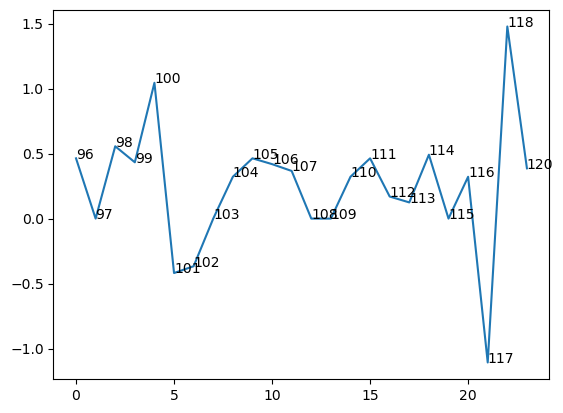

In [6]:

plt.plot(angles_3)
x = 0
for id in ids_3:
    y = angles_3[x]
    plt.text(x,y, str(id))
    x +=1

In [7]:
angles_3[:][1]

0.0

In [8]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(120)

{'_id': 120,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 3,
 'ratio_conn': 0,
 'DbConnectivity': {'pre_synaptique': [85],
  'post_synaptique': [],
  'lateral_connexion': [118, 119, 121],
  'weights': {},
  'angles': {118: -2.7549173768181623, 119: -1.276795025021113}},
 'meta': {'center': {'x': 0, 'y': 0},
  'matrix_width': 1,
  'pxl_coord': [(14, 20), (15, 18), (15, 19)],
  'glbl_prm': {'cg': {'x': 14.666666666666666, 'y': 19.0},
   'u_axis': {'x': -0.4718579255320244, 'y': 0.8816745987679439}},
  'angles': {}}}

In [9]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(121)

{'_id': 121,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 3,
 'ratio_conn': 0,
 'DbConnectivity': {'pre_synaptique': [80],
  'post_synaptique': [],
  'lateral_connexion': [120, 122],
  'weights': {},
  'angles': {120: -2.6501957919661288}},
 'meta': {'center': {'x': 0, 'y': 0},
  'matrix_width': 1,
  'pxl_coord': [(15, 17), (15, 18), (15, 19)],
  'glbl_prm': {'cg': {'x': 15.0, 'y': 18.0},
   'u_axis': {'x': -0.0, 'y': -0.9999999999999999}},
  'angles': {}}}

In [10]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(119)

{'_id': 119,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 3,
 'ratio_conn': 0,
 'DbConnectivity': {'pre_synaptique': [84],
  'post_synaptique': [],
  'lateral_connexion': [117, 120],
  'weights': {},
  'angles': {117: 3.141592653589793}},
 'meta': {'center': {'x': 0, 'y': 0},
  'matrix_width': 1,
  'pxl_coord': [(11, 18), (13, 20), (11, 19), (12, 18), (12, 19)],
  'glbl_prm': {'cg': {'x': 11.8, 'y': 18.8},
   'u_axis': {'x': 0.7071067811865478, 'y': 0.7071067811865474}},
  'angles': {}}}

In [11]:
new_pxl_coord = set()
new_pxl_coord.update(set(sbrain.nnet[0].nrn_tls.get_neuron_from_id(49)["meta"]["pxl_coord"]))
new_pxl_coord .update(set(sbrain.nnet[0].nrn_tls.get_neuron_from_id(50)["meta"]["pxl_coord"]))

new_pxl_coord = list(new_pxl_coord)
pca = PCA(n_components=1)
pca.fit(new_pxl_coord)
print(pca.components_[0][0])
print(pca.components_[0][1])



0.9486832980505138
0.316227766016838


In [12]:
np.pi + -2.677945044588987

0.46364760900080615

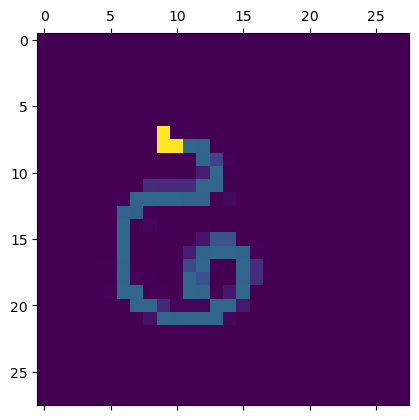

In [13]:
sbrain.nnet[0].show_receptive_field_id(48)

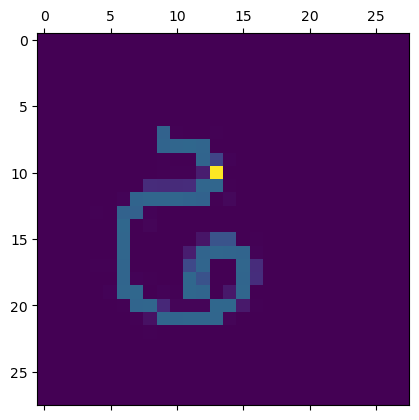

In [14]:
sbrain.nnet[0].show_receptive_field_id(99)

In [15]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(94)

{'_id': 94,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 2,
 'ratio_conn': 0,
 'DbConnectivity': {'pre_synaptique': [41.0, 42.0, 46.0, 47.0],
  'post_synaptique': [],
  'lateral_connexion': [88, 89, 93, 94],
  'weights': {94: 1, 93: 1, 89: 1, 88: 1},
  'angles': {93: -2.9097688490893905,
   89: -0.13914982950255525,
   88: -1.802620131295298}},
 'meta': {'center': {'x': 13, 'y': 21},
  'matrix_width': 3,
  'sub_pxl_map': array([[ 0., 41., 42.],
         [46., 47.,  0.],
         [ 0.,  0.,  0.]]),
  'pxl_coord': [(13, 21), (12, 21), (14, 20), (13, 20)],
  'glbl_prm': {'cg': {'x': 13.0, 'y': 20.5},
   'u_axis': {'x': 0.8506508083520399, 'y': -0.5257311121191336}}}}

In [16]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(88)

{'_id': 88,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 2,
 'ratio_conn': 0,
 'DbConnectivity': {'pre_synaptique': [37.0, 41.0, 42.0, 46.0, 47.0],
  'post_synaptique': [],
  'lateral_connexion': [84, 88, 89, 93, 94],
  'weights': {94: 1, 93: 1, 89: 1, 88: 1, 84: 1},
  'angles': {94: 1.802620131295298,
   93: -1.107148717794092,
   89: 1.6634703017927424,
   84: 3.141592653589793}},
 'meta': {'center': {'x': 13, 'y': 20},
  'matrix_width': 3,
  'sub_pxl_map': array([[37.,  0.,  0.],
         [ 0., 41., 42.],
         [46., 47.,  0.]]),
  'pxl_coord': [(13, 21), (12, 21), (14, 20), (13, 20), (12, 19)],
  'glbl_prm': {'cg': {'x': 12.8, 'y': 20.2},
   'u_axis': {'x': -0.7071067811865465, 'y': -0.7071067811865486}}}}

In [17]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(118)

{'_id': 118,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 3,
 'ratio_conn': 0,
 'DbConnectivity': {'pre_synaptique': [89],
  'post_synaptique': [],
  'lateral_connexion': [117, 120],
  'weights': {},
  'angles': {117: -1.6634703017927444}},
 'meta': {'center': {'x': 0, 'y': 0},
  'matrix_width': 1,
  'pxl_coord': [(13, 20), (13, 21), (15, 19), (14, 20)],
  'glbl_prm': {'cg': {'x': 13.75, 'y': 20.0},
   'u_axis': {'x': 0.7695091081495349, 'y': -0.6386358371363975}},
  'angles': {}}}

In [18]:
sbrain.nnet[0].nrn_tls.get_neuron_from_id(119)

{'_id': 119,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 3,
 'ratio_conn': 0,
 'DbConnectivity': {'pre_synaptique': [84],
  'post_synaptique': [],
  'lateral_connexion': [117, 120],
  'weights': {},
  'angles': {117: 3.141592653589793}},
 'meta': {'center': {'x': 0, 'y': 0},
  'matrix_width': 1,
  'pxl_coord': [(11, 18), (13, 20), (11, 19), (12, 18), (12, 19)],
  'glbl_prm': {'cg': {'x': 11.8, 'y': 18.8},
   'u_axis': {'x': 0.7071067811865478, 'y': 0.7071067811865474}},
  'angles': {}}}

In [19]:
nrn_1 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(94)
vector_1 = nrn_1["meta"]["glbl_prm"]["u_axis"]
nrn_2 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(118)
vector_2 = nrn_2["meta"]["glbl_prm"]["u_axis"]
sbrain.nnet[0].nrn_tls.calc_angle(vector_1, vector_2)

-0.13914982950255525

In [20]:
nrn_1 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(116)
vector_1 = nrn_1["meta"]["glbl_prm"]["u_axis"]
nrn_2 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(115)
vector_2 = nrn_2["meta"]["glbl_prm"]["u_axis"]
sbrain.nnet[0].nrn_tls.calc_angle(vector_1, vector_2)

0.32175055439664196

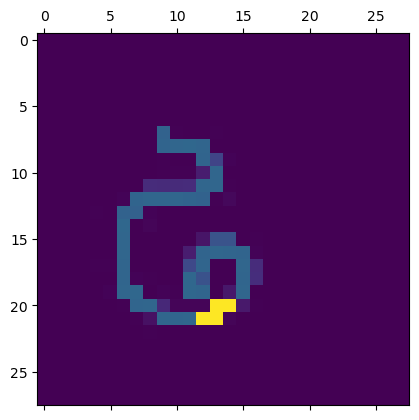

In [21]:
sbrain.nnet[0].show_receptive_field_id(94)

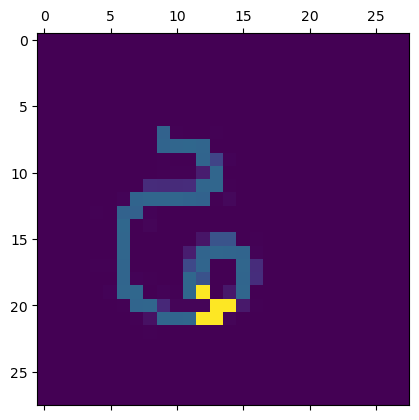

In [22]:
sbrain.nnet[0].show_receptive_field_id(88)

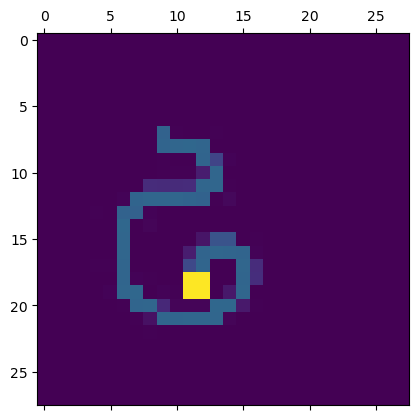

In [23]:
sbrain.nnet[0].show_receptive_field_id(83)

In [24]:
nrn_1 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(75)
vector_1 = nrn_1["meta"]["glbl_prm"]["u_axis"]
nrn_2 = sbrain.nnet[0].nrn_tls.get_neuron_from_id(70)
vector_2 = nrn_2["meta"]["glbl_prm"]["u_axis"]
sbrain.nnet[0].nrn_tls.calc_angle(vector_1, vector_2)

/Users/oliviermanette/Documents/Sentive One Shot Learning Omniglot/sandbox metadl/../metadl/baselines/sentive_ai/sentive/sentive_neuron_helper.py:386: RuntimeWarning: invalid value encountered in arccos
  angle =  signe * np.arccos(np.sum(np.multiply(np_c_1,np_c_2))/(np.sqrt(np.sum(np.power(np_c_1,2)))*np.sqrt(np.sum(np.power(np_c_2,2)))))


3.141592653589793

In [25]:
np_c_1 = np.array([-0.52573111, 0.85065081])
np_c_2 = np.array([-0.52573111, 0.85065081])

In [26]:
np.arccos(np.sum(np.multiply(np_c_1,np_c_2))/(np.sqrt(np.sum(np.power(np_c_1,2)))*np.sqrt(np.sum(np.power(np_c_2,2)))))

0.0

47


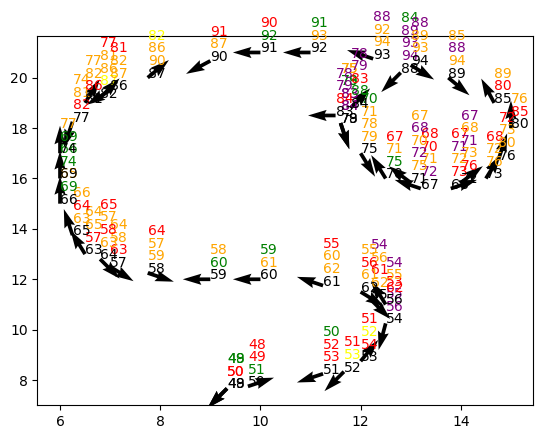

In [27]:
X = []
Y = []
u_x = []
u_y = []
nb = 0
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        nb += 1
        X.append(nrn2["meta"]["glbl_prm"]["cg"]["x"])
        Y.append(nrn2["meta"]["glbl_prm"]["cg"]["y"])
        u_x.append(nrn2["meta"]["glbl_prm"]["u_axis"]["x"])
        u_y.append(nrn2["meta"]["glbl_prm"]["u_axis"]["y"])
q = plt.quiver(X,Y,u_x,u_y)
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        x = nrn2["meta"]["glbl_prm"]["cg"]["x"]
        y = nrn2["meta"]["glbl_prm"]["cg"]["y"]
        plt.text(x,y, str(nrn2["_id"]))
        for key in nrn2["DbConnectivity"]['angles']:
            y += 0.5
            angle = nrn2["DbConnectivity"]['angles'][key]
            angle = np.abs(angle)
            if angle > (np.pi)/2:
                angle = np.pi - angle
            if angle ==0:
                color = "green"
            elif angle < 0.1:
                color = "yellow"
            elif angle < 0.4:
                color = "orange"
            elif angle < 0.8:
                color = "red"
            else :
                color = "purple"
            plt.text(x,y, str(key),color=color)
            
print(nb)

33


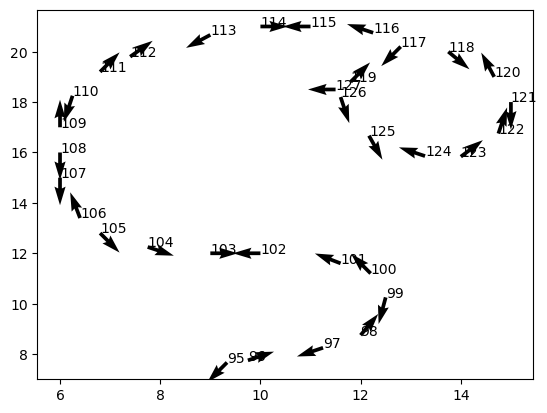

In [28]:
sbrain.nnet[0].show_layer_vectors(3, False)

(array([26., 30., 26., 26.,  8.,  4.,  4.,  8.,  6.,  4.]),
 array([0.        , 0.14781224, 0.29562447, 0.44343671, 0.59124894,
        0.73906118, 0.88687341, 1.03468565, 1.18249788, 1.33031012,
        1.47812235]),
 <BarContainer object of 10 artists>)

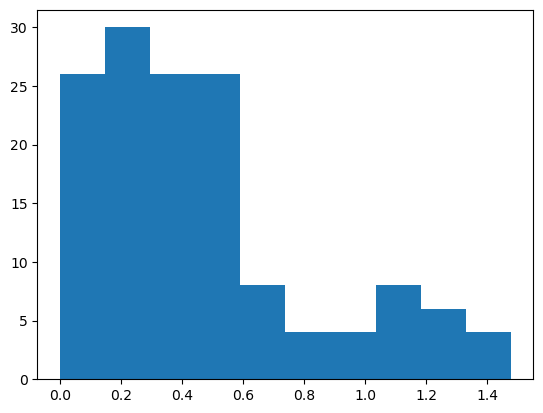

In [29]:
angles = []
for nrn in sbrain.nnet[0].nrn_tls.lst_nrns:
    if nrn.neuron["layer_id"] == 2:
        nrn2 = nrn.neuron
        for angle in nrn2["DbConnectivity"]['angles'].values():
            angle = np.abs(angle)
            if angle > (np.pi)/2:
                angle = np.pi - angle
            angles.append(angle)
            
plt.hist(angles)

In [30]:
sbrain.nnet[0]

In [31]:
nrn3

{'_id': 95,
 'schema_version': 2,
 'type': 'sentive_vision_arcs',
 'layer_id': 3,
 'ratio_conn': 0,
 'DbConnectivity': {'pre_synaptique': [48],
  'post_synaptique': [],
  'lateral_connexion': [96],
  'weights': {}},
 'meta': {'center': {'x': 0, 'y': 0},
  'matrix_width': 1,
  'glbl_prm': {'cg': {'x': 9.333333333333334, 'y': 7.666666666666667},
   'u_axis': {'x': -0.7071067811865474, 'y': -0.7071067811865477}}}}

In [32]:
A = {1:{"super":"genial"}}

In [33]:
A.pop(list(A.keys())[0])

{'super': 'genial'}